In [1]:
import models, losses, plotting_utils, multicoil_motion_simulator
from interlacer import utils

from matplotlib import pyplot as plt
import numpy as np
import os
import tensorflow as tf

import mghGErecon as ge
import importlib

In [2]:
base_data_dir = '/vast/kmotion/users/nmsingh/dev/ismrm2022/multicoil_data_splits_obofix'
val_dir = os.path.join(base_data_dir,'test')

dir_list = os.listdir(val_dir)
dir_list = [file for file in dir_list if file[-4:]=='.npz']
i = 11
ex = dir_list[i]

batch_size=1
sl_files = [ex]

scan_data = ex.split('.')[0].split('_')[:4]
scan_data.insert(2,'recon')
scan_data.insert(0,'/vast/kmotion/data/data_anon/data_chelsea')
sl = int(ex.split('.')[0].split('_')[4])
k_corrupts = []
k_trues = []

for sl in sl_files:
    if sl in dir_list:
        ex_arch = np.load(os.path.join(val_dir, sl))
        
        res_info = np.load(os.path.join('/'.join(scan_data),'resolutioninfo.npz'))
        psx = res_info['pixelSizeX']
        psy = res_info['pixelSizeY']

        k_corrupt = ex_arch['k_corrupt']
        k_true = ex_arch['k_true']

        norm = np.max(plotting_utils.rss_image_from_multicoil_k(k_corrupt[0,:,:,:]).flatten())
        k_corrupt /= norm
        k_true /=norm

        k_corrupts.append(k_corrupt)
        k_trues.append(k_true)


v_in = np.concatenate(k_corrupts,axis=0)
v_out = np.concatenate(k_trues,axis=0)


In [3]:
num_coils=44

In [4]:
model = models.get_multicoil_interlacer_model(
        (None, None, 2*num_coils),
        '3-piece',
        9,
        64,
        1,
        6,
        num_coils)

In [5]:
multicoil_ssim = losses.multicoil_ssim('FREQ',num_coils)

In [6]:
lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        lr=lr),
    loss=multicoil_ssim,
    loss_weights=1)


In [7]:
v_grappa = ge.recon.recon_arc_kspace(utils.join_reim_channels(tf.convert_to_tensor(v_in))[0,...],'/'.join(scan_data))
v_grappa = utils.split_reim_channels(tf.expand_dims(v_grappa,0))


running ARC recon, input dims: (416, 300, 44)
psdnameannot:  
psd_iname: FSE
psdname: fse-xl
pseq: 19.0
se_desc: ANONYMIZED
 ----
 sequence is 2DFSE 
 ----
target of GERecon.so symlink is:
	/vast/kmotion/code/ge-orchestra/orchestra-sdk-1.10-1/orchestra-sdk-1.10-1.python/GERecon.so.python35
orchestra_version: 	orchestra-sdk-1.10-1.python
gerecon_version: 	GERecon.so.python35
  running ARC on slice: 0


In [8]:
epoch = str(1850).zfill(4)
model.load_weights('training/FINAL_interlacer_noshift/44-INTERLACER_RESIDUAL-9-64-1-6-multicoil_ssim-FREQ-FREQ-3-piece-5000-6/cp-'+epoch+'.ckpt')


In [9]:
v_model = model(v_in)

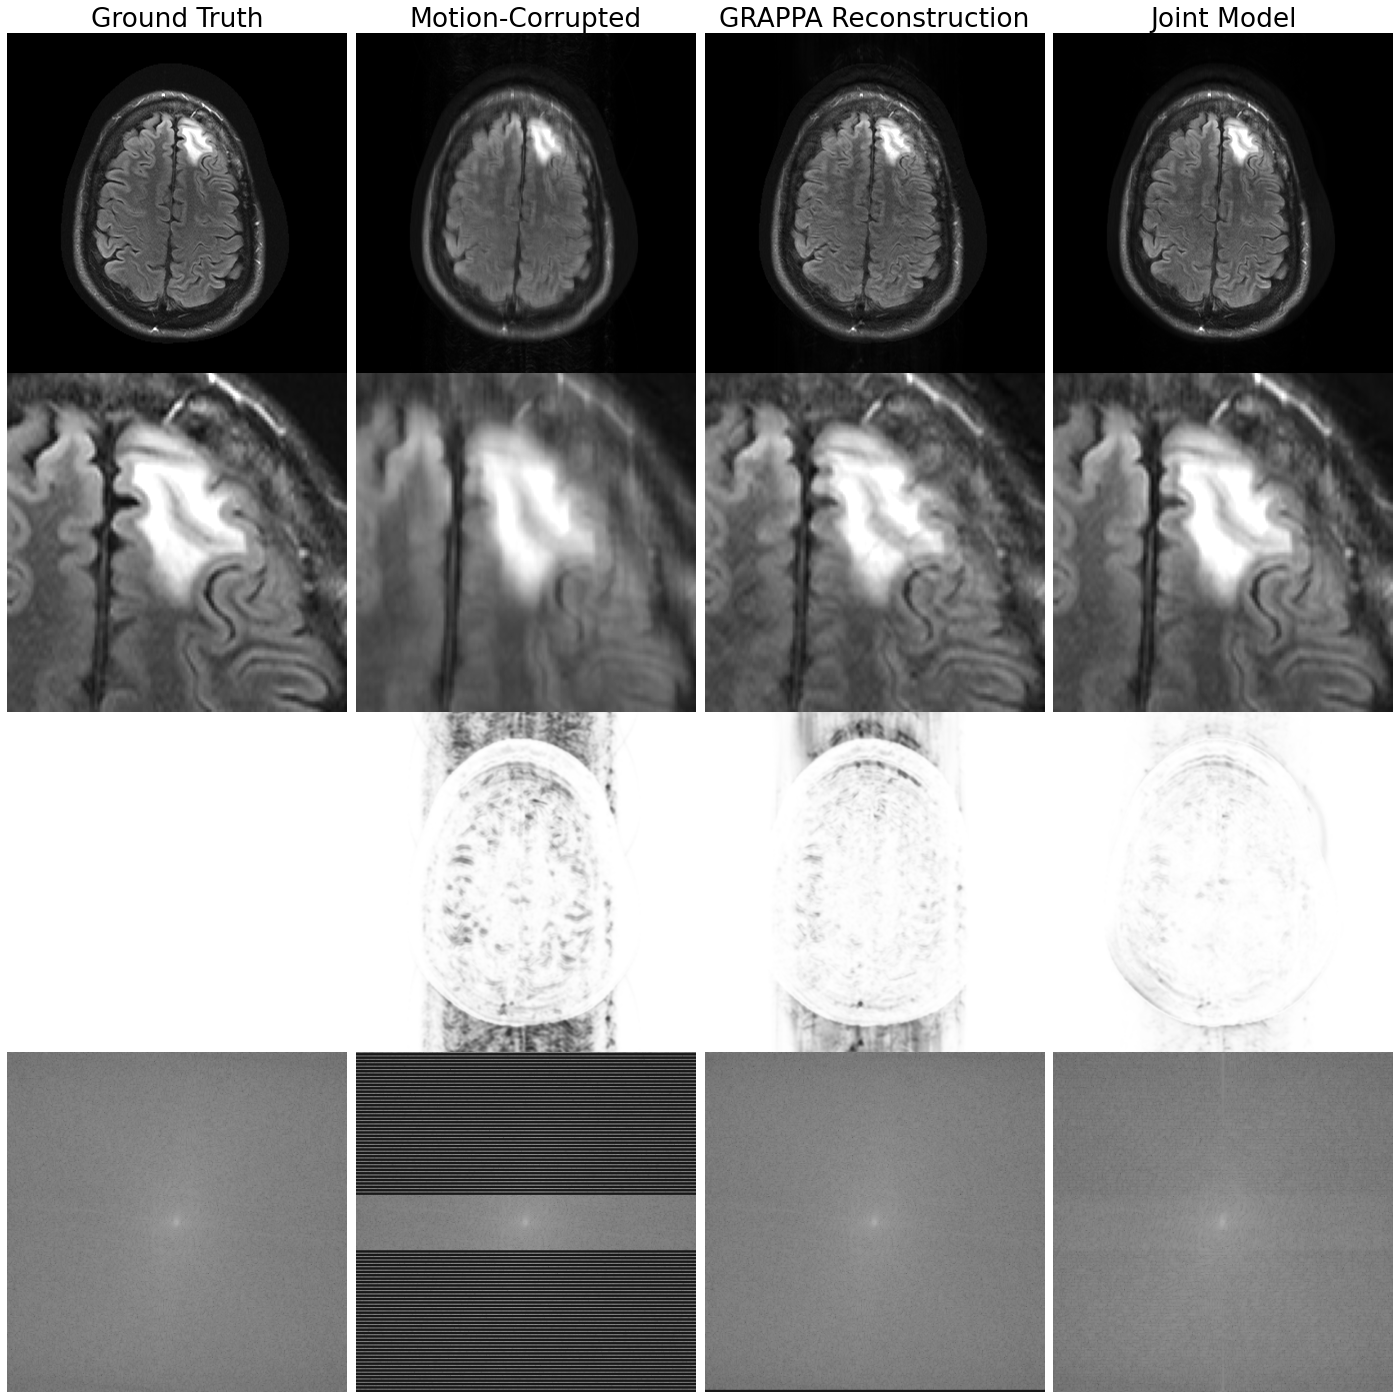

In [10]:
importlib.reload(plotting_utils)
plotting_utils.plot_comparison_results(v_out,v_in,[v_grappa,v_model],['GRAPPA Reconstruction',
                                                                     'Joint Model'],psx=psx,psy=psy,ind=0,vmin=0,vmax=1.2)